In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from diffprivlib.models import LogisticRegression as DPLR

from data_prep import convert_to_cat, one_hot_encode
from dp_synthesis import get_synthesizer, get_quail_synthesizer, save_synthetic_data, plot_distributions
from classification_metrics import get_classification_summary, get_table_metrics, get_epsilon_plots
from dp_model_metrics import dp_model_classification_helper, get_dp_model_table_metrics

from kanon import convert_to_str, get_spans, partition_dataset, is_k_anonymous, build_anonymized_dataset, drop_grouped_rows

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 1. Convert all columns to categorical

In [3]:
# Read in the original data
compas_url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
compas_data = pd.read_csv(compas_url)
compas_data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [4]:
# Get the categorical data
cat_compas = convert_to_cat(compas_data, dataset="compas")
cat_compas

,age,priors_count,sex,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree,length_of_stay,race,two_year_recid
1,0,0,1,0,0,0,0,0,0,0
2,1,1,1,0,0,1,0,0,0,0
6,2,2,1,0,0,0,0,0,1,0
8,2,0,0,0,0,0,1,0,1,1
10,0,0,1,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
7207,0,0,1,0,0,0,1,0,0,0
7208,1,0,1,0,0,0,0,0,0,1
7209,1,0,1,0,0,0,0,0,0,1
7210,1,0,1,0,0,0,0,0,0,1


In [5]:
# Get the one-hot encoded data
encoded_compas = one_hot_encode(cat_compas, dataset="compas")
encoded_compas

,sex,c_charge_degree,race,two_year_recid,age_1,age_2,age_3,age_4,priors_count_1,priors_count_2,...,juv_other_count_2,juv_other_count_3,juv_other_count_4,juv_other_count_5,juv_other_count_6,juv_other_count_7,length_of_stay_1,length_of_stay_2,length_of_stay_3,length_of_stay_4
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,1,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,0,1,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7207,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7208,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7209,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7210,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# Split the categorical and one-hot encoded data into train and test
cat_train, cat_test = train_test_split(cat_compas, test_size=0.2, random_state=0)
encoded_train, encoded_test = train_test_split(encoded_compas, test_size=0.2, random_state=0)

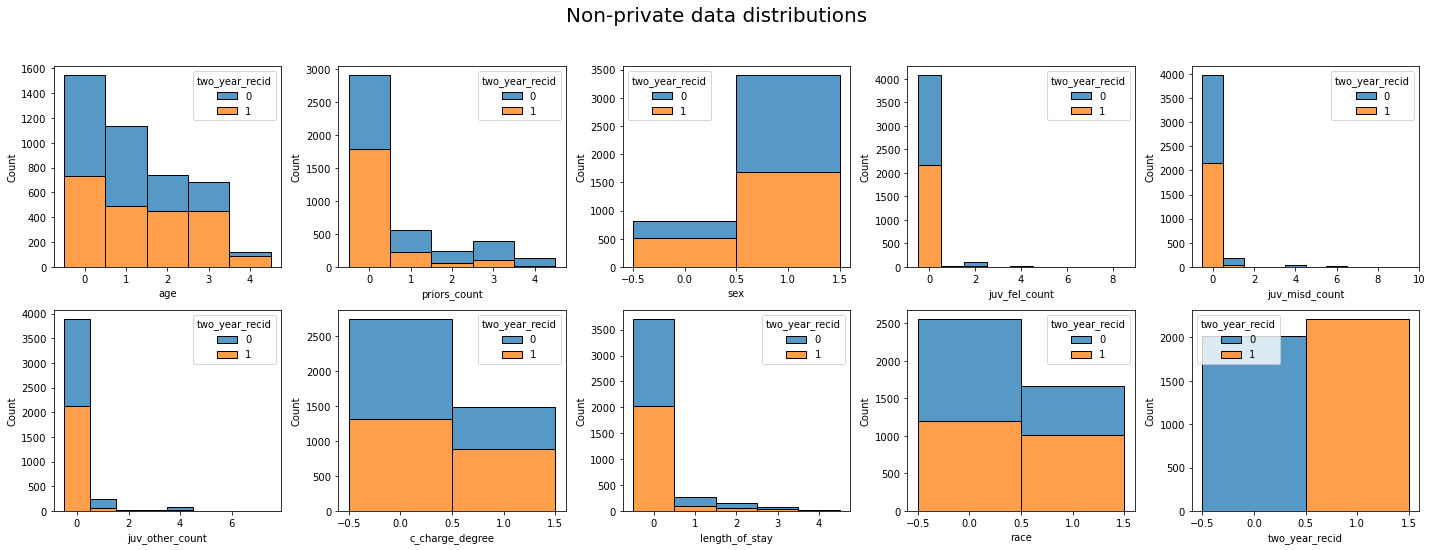

In [7]:
# Plot the non-private distributions
plot_distributions(cat_train, title="Non-private data distributions", dataset="compas")

# 2. Train binary classifier on non-private data

In [8]:
y_train_pred, y_test_pred = get_classification_summary(encoded_train, encoded_test, classifier="logistic", dataset="compas")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
Black: 0.6082, White: 0.7612

False positive rates:
Black: 0.3102, White: 0.6325

Equalized odds distances:
y=1: 0.1530, y=0: 0.3223

Classification accuracies:
Black: 0.6479, White: 0.6106

F1-score: 0.6723

Avg train pred: 0.5647, Avg test pred: 0.5653


In [9]:
y_train_pred, y_test_pred = get_classification_summary(encoded_train, encoded_test, classifier="forest", dataset="compas")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (forest, eval on test data)

True positive rates:
Black: 0.5893, White: 0.8097

False positive rates:
Black: 0.3531, White: 0.7410

Equalized odds distances:
y=1: 0.2204, y=0: 0.3878

Classification accuracies:
Black: 0.6174, White: 0.5991

F1-score: 0.6628

Avg train pred: 0.5905, Avg test pred: 0.6013


# 3. New MWEM synthesis

In [10]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [ ]:
# Generate 10 repetitions of synthetic data with MWEM
save_synthetic_data(epsilon_vals, cat_train, synthesizer="MWEM", n_reps=10, dataset="compas", results_dir="compas/")

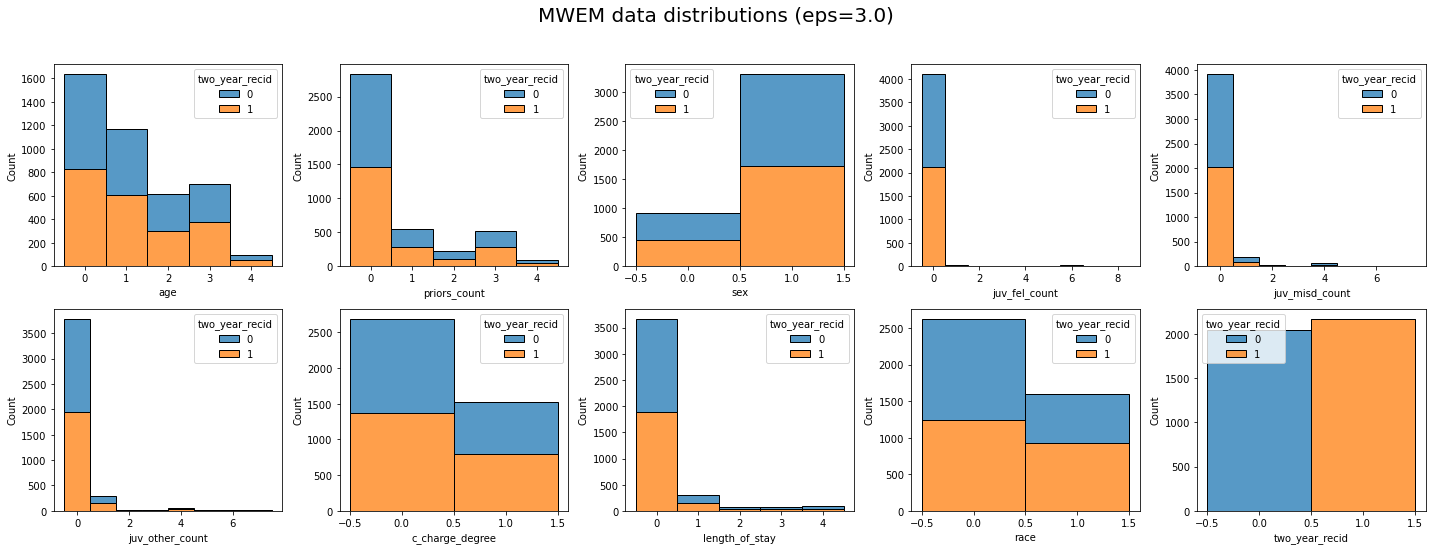

In [13]:
MWEM_eps3_rep0 = pd.read_csv("compas/MWEM_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(MWEM_eps3_rep0, title="MWEM data distributions (eps=3.0)", dataset="compas")

In [17]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.877
FPR difference median: 0.802
F1-score median: 0.542


In [15]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("MWEM", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.534
FPR difference median: 0.526
F1-score median: 0.559


# 4. New DP-CTGAN synthesis

In [ ]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, cat_train, synthesizer="DPCTGAN", n_reps=10, dataset="compas", results_dir="compas/")

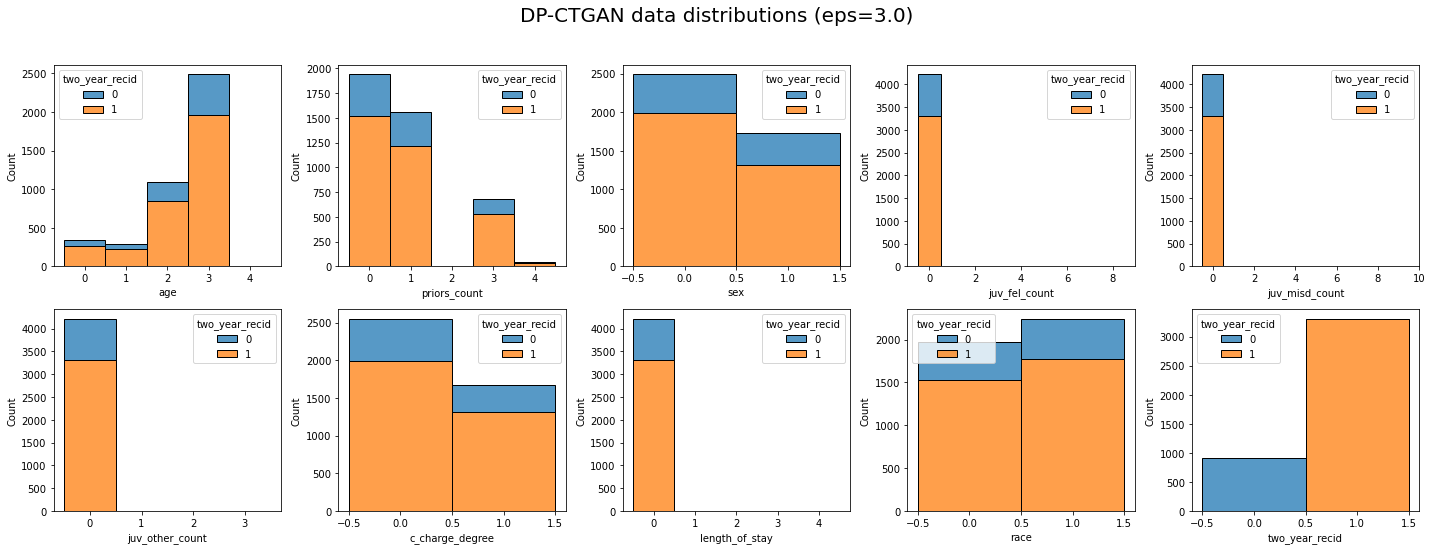

In [20]:
DPCTGAN_eps3_rep0 = pd.read_csv("compas/DPCTGAN_eps=3.0_rep=0.csv", index_col=0)
plot_distributions(DPCTGAN_eps3_rep0, title="DP-CTGAN data distributions (eps=3.0)", dataset="compas")

In [21]:
# Plot the table metrics for DPCTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.715


In [22]:
# Plot the table metrics for DPCTGAN with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.016
FPR difference median: 0.012
F1-score median: 0.712


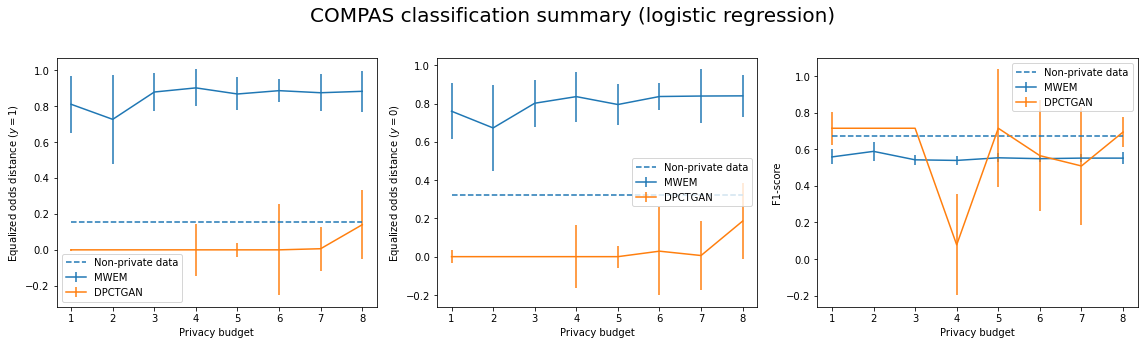

In [23]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/")

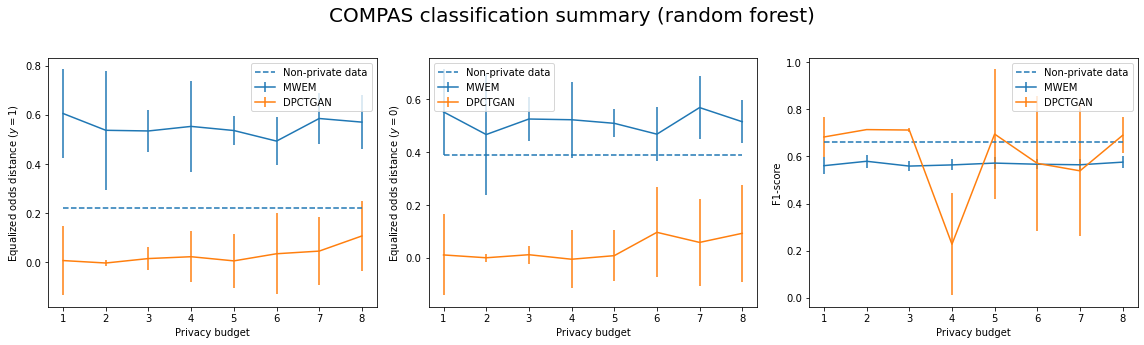

In [24]:
# Plot new MWEM and DP-CTGAN results at range of epsilon values
get_epsilon_plots(["MWEM", "DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/")

# 5. New PATE-CTGAN synthesis (tuning)

In [25]:
# Set range of epsilon values
epsilon_vals = [3.0]

In [27]:
# Generate 10 repetitions of synthetic data with PATECTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="PATECTGAN", n_reps=10, dataset="compas", 
                    embedding_dim=128, generator_dim=(256,256), discriminator_dim=(256,256), batch_size=500, 
                    noise_multiplier=1e-3, sigma=5, results_dir="compas/")

Completed eps=3.0, rep=1.
Completed eps=3.0, rep=2.
Completed eps=3.0, rep=3.
Completed eps=3.0, rep=4.
Completed eps=3.0, rep=5.
Completed eps=3.0, rep=6.
Completed eps=3.0, rep=7.
Completed eps=3.0, rep=8.
Completed eps=3.0, rep=9.
Completed eps=3.0, rep=10.


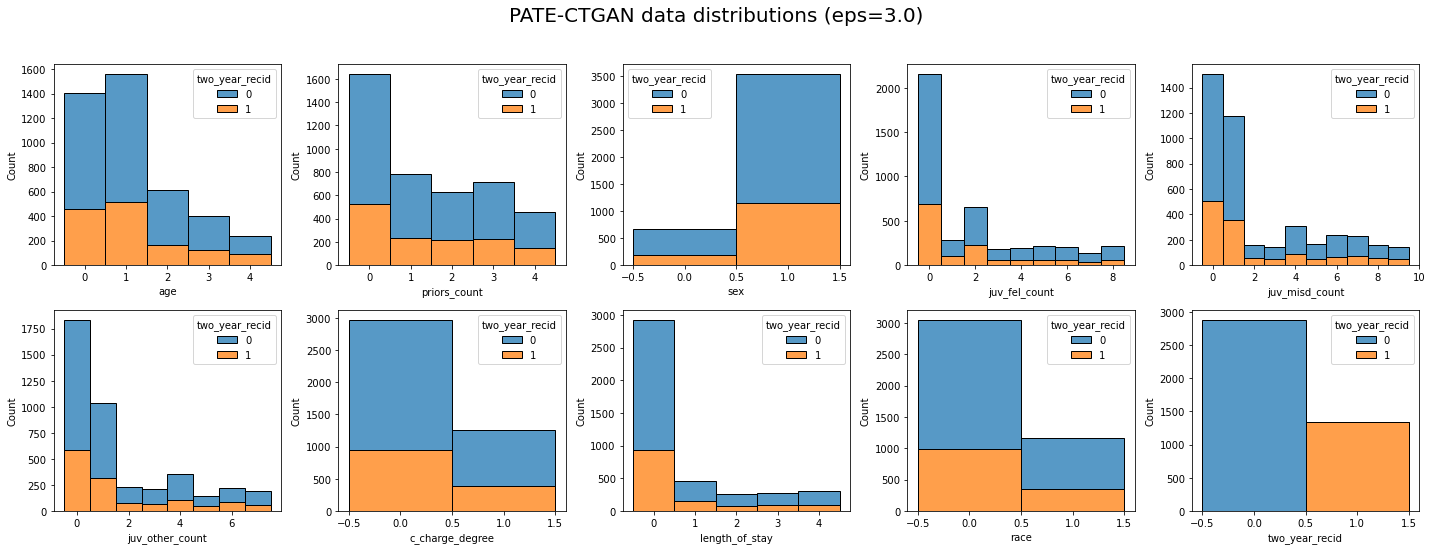

In [31]:
# Plot distributions of third repetition
PATECTGAN_eps3_rep2 = pd.read_csv("compas/PATECTGAN_eps=3.0_rep=2.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep2, title="PATE-CTGAN data distributions (eps=3.0)", dataset="compas")

In [32]:
# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.000


In [33]:
# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.128
FPR difference median: 0.144
F1-score median: 0.315


In [ ]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, processed_train, synthesizer="PATECTGAN", n_reps=5, dataset="adult", 
                    embedding_dim=128, generator_dim=(256,256), discriminator_dim=(256,256), batch_size=200, 
                    noise_multiplier=1e-3, sigma=5)

# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=epsilon_vals, nreps=5, classifier="logistic", test_df=processed_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

# Plot distributions of third repetition
PATECTGAN_eps3_rep2 = pd.read_csv("PATECTGAN_eps=3.0_rep=2.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep2, title="PATE-CTGAN data distributions (eps=3.0)")

In [ ]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, processed_train, synthesizer="PATECTGAN", n_reps=5, dataset="adult", 
                    embedding_dim=64, generator_dim=(128,128), discriminator_dim=(128,128), batch_size=500, 
                    noise_multiplier=1e-3, sigma=5)

# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=epsilon_vals, nreps=5, classifier="logistic", test_df=processed_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

# Plot distributions of third repetition
PATECTGAN_eps3_rep2 = pd.read_csv("PATECTGAN_eps=3.0_rep=2.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep2, title="PATE-CTGAN data distributions (eps=3.0)")

In [ ]:
# Generate 10 repetitions of synthetic data with DP-CTGAN 
save_synthetic_data(epsilon_vals, processed_train, synthesizer="PATECTGAN", n_reps=5, dataset="adult", 
                    embedding_dim=32, generator_dim=(64,64), discriminator_dim=(64,64), batch_size=100, 
                    noise_multiplier=1e-3, sigma=5)

# Plot the table metrics for PATECTGAN with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("PATECTGAN", epsilon_list=epsilon_vals, nreps=5, classifier="logistic", test_df=processed_test)
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

# Plot distributions of third repetition
PATECTGAN_eps3_rep2 = pd.read_csv("PATECTGAN_eps=3.0_rep=2.csv", index_col=0)
plot_distributions(PATECTGAN_eps3_rep2, title="PATE-CTGAN data distributions (eps=3.0)")

# 6. New QUAIL-MWEM synthesis

In [7]:
# Set range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

In [ ]:
# Generate 10 repetitions of synthetic data with QUAIL-MWEM
save_synthetic_data(epsilon_vals, cat_train, synthesizer="MWEM", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="compas", results_dir="compas/")

In [8]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.101
FPR difference median: 0.151
F1-score median: 0.637


In [37]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.107
FPR difference median: 0.160
F1-score median: 0.609


# 7. New QUAIL-DPCTGAN synthesis

In [ ]:
# Generate 10 repetitions of synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="DPCTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="compas", results_dir="compas/")

In [55]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.093
FPR difference median: 0.017
F1-score median: 0.181


In [56]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.059
FPR difference median: 0.003
F1-score median: 0.244


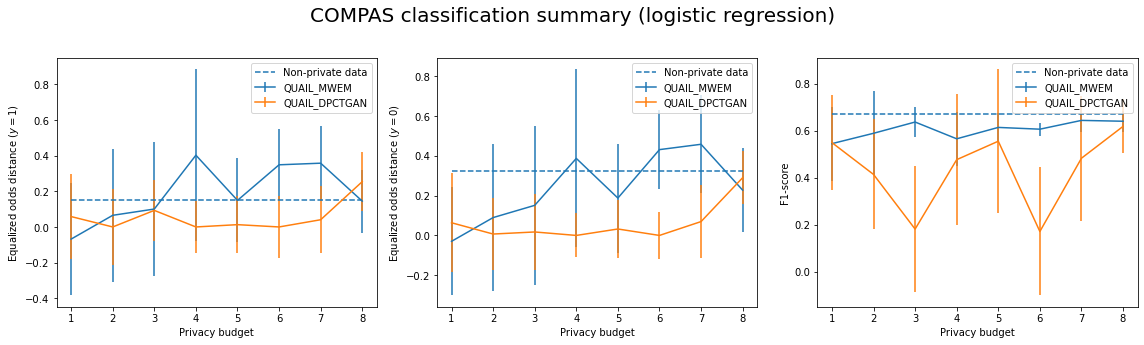

In [57]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/")

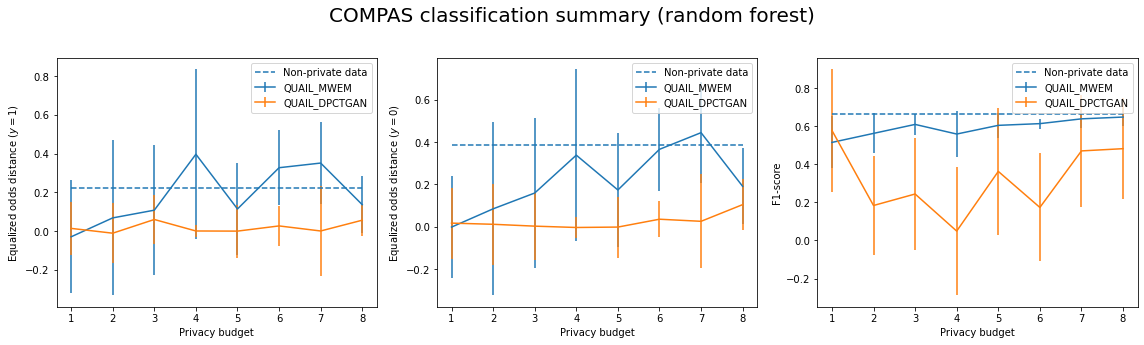

In [58]:
# Plot new MWEM results at range of epsilon values
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/")

# 8. New QUAIL-PATECTGAN synthesis

In [45]:
# error: epsilon=1.0 too small?
epsilon_vals = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [ ]:
# Generate 10 repetitions of synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, cat_train, synthesizer="PATECTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="compas", results_dir="compas/")

In [47]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.133
FPR difference median: 0.117
F1-score median: 0.553


In [48]:
# Plot the table metrics for MWEM with random forest
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="forest", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: -0.001
FPR difference median: -0.017
F1-score median: 0.290


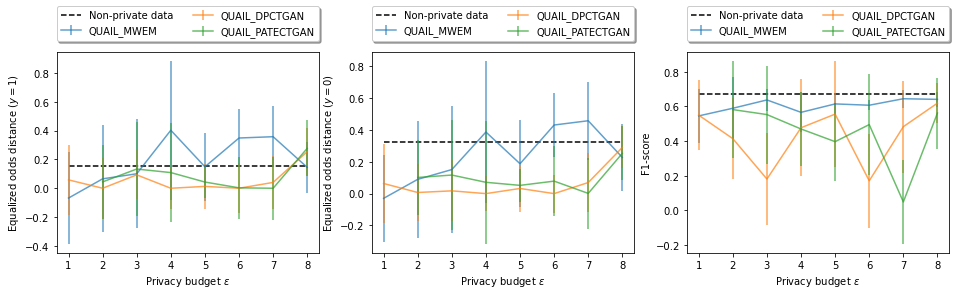

In [10]:
# Plot all results at range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/", savefig=True)

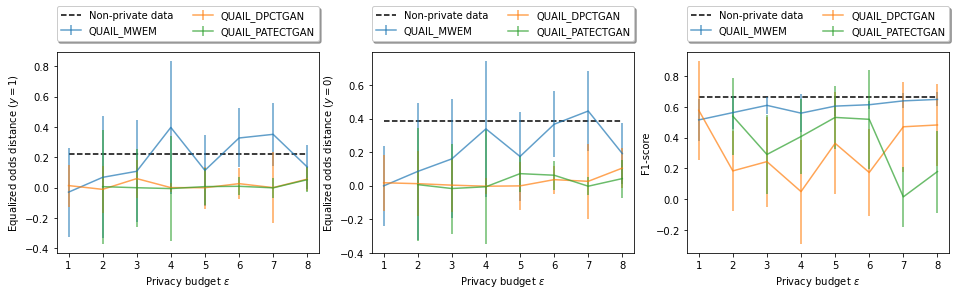

In [11]:
# Plot all results at range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/", savefig=True)

# 9. Comparison to DPLR

In [51]:
# Set range of epsilon values
epsilon_vals = [3.0]

# Calculate the median results
tpr_diff_median, fpr_diff_median, f1_score_median = get_dp_model_table_metrics(epsilon_vals, nreps=10, classifier="logistic", train_df=encoded_train, test_df=encoded_test, dataset="compas")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.179
FPR difference median: 0.314
F1-score median: 0.673


# 10. Comparison to k-anonymity

In [12]:
# Convert categorical data into format required by k-anonymization algo
str_cat_train = convert_to_str(cat_train)

In [13]:
# Get the spans of the categorical variables
full_spans = get_spans(str_cat_train, str_cat_train.index)

In [14]:
# Specify the feature columns and label
feature_columns = ['age','priors_count','sex','juv_fel_count', 'juv_misd_count',
                   'juv_other_count', 'c_charge_degree', 'length_of_stay','race','two_year_recid']
sensitive_column = "two_year_recid"

# Make partitions for k=3
finished_partitions = partition_dataset(str_cat_train, feature_columns, sensitive_column, full_spans, is_k_anonymous, k=5)

# Get the number of partitions created
len(finished_partitions)

233

In [15]:
# Build anonymized data set
kanon_df = build_anonymized_dataset(str_cat_train, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...
Finished 101 partitions...
Finished 201 partitions...


In [16]:
# Drop rows with grouped categories
kanon_df = drop_grouped_rows(kanon_df, dataset="compas")
kanon_df

,age,priors_count,sex,juv_fel_count,juv_misd_count,juv_other_count,c_charge_degree,length_of_stay,race,two_year_recid
0,1,3,1,0,0,3,0,3,0,0
1,1,3,1,0,0,3,0,3,0,1
2,2,2,1,8,0,0,0,3,0,0
3,2,2,1,8,0,0,0,3,0,1
4,3,1,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
241,1,0,1,0,0,0,0,0,0,0
242,1,0,1,0,0,0,0,0,1,0
243,1,0,1,0,0,1,0,0,1,0
244,1,0,1,0,1,0,0,0,1,0


In [17]:
# One-hot encode the k-anonymized data
encoded_kanon = one_hot_encode(kanon_df, dataset="compas")

# Get classification summary for k-anonymized training data
y_train_pred, y_test_pred = get_classification_summary(encoded_kanon, encoded_test, classifier="logistic", dataset="compas")
print(f"Avg train pred: {np.mean(y_train_pred):.4f}, Avg test pred: {np.mean(y_test_pred):.4f}")


CLASSIFICATION RESULTS (logistic, eval on test data)

True positive rates:
Black: 0.4420, White: 0.6269

False positive rates:
Black: 0.1914, White: 0.4277

Equalized odds distances:
y=1: 0.1849, y=0: 0.2363

Classification accuracies:
Black: 0.6206, White: 0.6060

F1-score: 0.6029

Avg train pred: 0.2805, Avg test pred: 0.4148


# 11. Pre-processing (undersampling before synth)

In [18]:
def multi_undersample(cat_df, protected_att, target):
    
    # Count the number of rows for each group and target label
    group0_counts = [len(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)]), len(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)])]
    group1_counts = [len(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)]), len(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)])]
    all_counts = group0_counts + group1_counts
    
    # Identify the minority count (w.r.t group and label)
    min_count_id = np.argmin(all_counts)
    min_count = all_counts[min_count_id]
    
    # Randomly drop rows from the same group and opposite label
    if min_count_id == 0:
        count_diff = all_counts[1] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(all_counts[2]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(all_counts[3]-min_count).index)
    elif min_count_id == 1:
        count_diff = all_counts[0] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(all_counts[2]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(all_counts[3]-min_count).index)
    elif min_count_id == 2:
        count_diff = all_counts[3] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==1)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(all_counts[0]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(all_counts[1]-min_count).index)
    else:
        count_diff = all_counts[2] - min_count
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==1) & (cat_df[target]==0)].sample(count_diff).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==0)].sample(all_counts[0]-min_count).index)
        cat_df = cat_df.drop(cat_df[(cat_df[protected_att]==0) & (cat_df[target]==1)].sample(all_counts[1]-min_count).index)    
    
    return cat_df

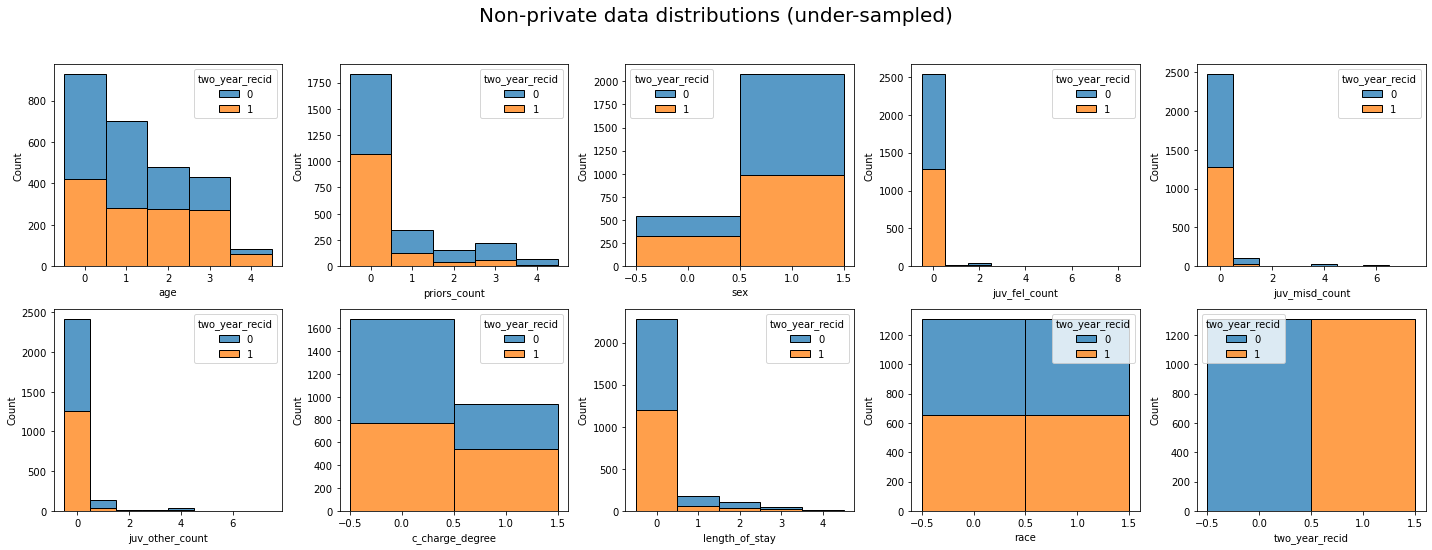

In [20]:
# Balance the groups and labels
multi_balanced = multi_undersample(cat_train, protected_att="race", target="two_year_recid")
plot_distributions(multi_balanced, title="Non-private data distributions (under-sampled)", dataset="compas")

In [ ]:
# Generate 10 repetitions of preprocessed synthetic data with QUAIL-MWEM
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="MWEM", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="compas", results_dir="compas/preprocessed/")

In [ ]:
# Generate 10 repetitions of preprocessed synthetic data with QUAIL-DPCTGAN
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="DPCTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="compas", results_dir="compas/preprocessed/")

In [ ]:
# Generate 10 repetitions of preprocessed synthetic data with QUAIL-DPCTGAN
epsilon_vals = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
save_synthetic_data(epsilon_vals, multi_balanced, synthesizer="PATECTGAN", quail=True, classifier="DPLR", eps_split=0.8, n_reps=10, dataset="compas", results_dir="compas/preprocessed/")

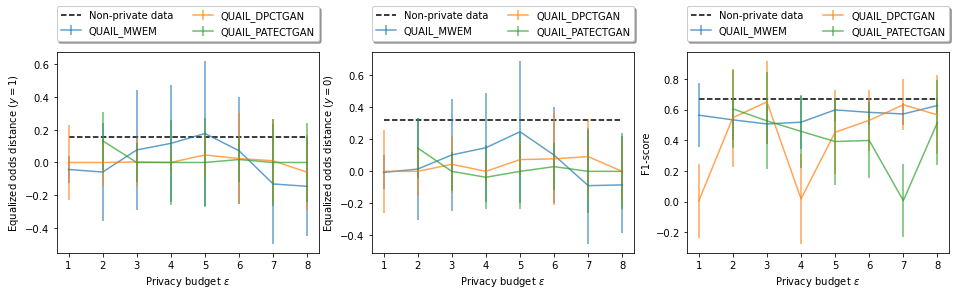

In [22]:
# Plot new MWEM results at range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="logistic", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/preprocessed/", savefig=True)

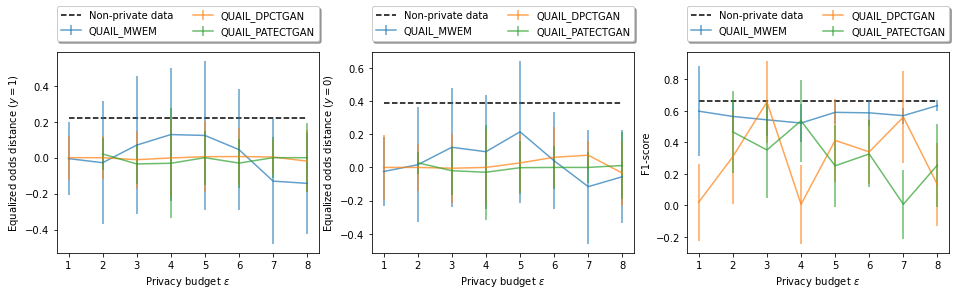

In [23]:
# Plot new MWEM results at range of epsilon values
epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
get_epsilon_plots(["QUAIL_MWEM", "QUAIL_DPCTGAN", "QUAIL_PATECTGAN"], epsilon_vals, nreps=10, classifier="forest", test_df=encoded_test, non_priv_train=cat_train, one_hot_encode_train=True, dataset="compas", results_dir="compas/preprocessed/", savefig=True)

In [24]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_MWEM", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/preprocessed/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.076
FPR difference median: 0.103
F1-score median: 0.507


In [25]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_DPCTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/preprocessed/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.003
FPR difference median: 0.044
F1-score median: 0.651


In [26]:
# Plot the table metrics for MWEM with logistic regression
tpr_diff_median, fpr_diff_median, f1_score_median = get_table_metrics("QUAIL_PATECTGAN", epsilon_list=[3.0], nreps=10, classifier="logistic", test_df=encoded_test, one_hot_encode_train=True, dataset="compas", results_dir="compas/preprocessed/")
print(f"TPR difference median: {tpr_diff_median:.3f}")
print(f"FPR difference median: {fpr_diff_median:.3f}")
print(f"F1-score median: {f1_score_median:.3f}")

TPR difference median: 0.000
FPR difference median: 0.000
F1-score median: 0.527
